# Health-Care-Data-Analysis

### - Modeling & Evaluating model performance (2) -

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import set_matplotlib_formats

In [3]:
# 폰트
plt.rc("font",family = "Malgun Gothic")

# 선명하게 글씨체를 출력시킬때 
set_matplotlib_formats('retina')

# 음수 값 출력
plt.rc('axes',unicode_minus=False)

# 최대 출력 column수 지정 
pd.options.display.max_columns = 100 

In [4]:
df = pd.read_csv('health_real_fin.csv', encoding='utf-8')
df['성별'] = df['성별'].astype('object')
df['흡연상태'] = df['흡연상태'].astype('object')
df['단백뇨'] = df['단백뇨'].astype('object')

In [5]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

C:\Users\Gyulee\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
dat = df.loc[:, ['심혈관질환', '허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', 'HDL콜레스테롤',
                 'LDL콜레스테롤', '혈색소', '단백뇨', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',
                 '흡연상태', '성별', '신장', '체중','BMI', '나이', 'eGFR', '기초대사량']]

In [7]:
# dat = df.loc[:, ['허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', 'HDL콜레스테롤',
#                  'LDL콜레스테롤', '혈색소', '단백뇨', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피',
#                  '흡연상태', '성별', '신장', '체중','BMI', '나이', 'eGFR', '기초대사량',
#                 '고혈압_k', '대사증후군_k', '당뇨_k', '빈혈_k', '단백뇨_k', 'whtr_k', '혈청크레아티닌_진단', 'eGFR_진단',
#                 '고지혈증', '고혈압', '신장질환', '심혈관질환',]]

## 심혈관질환 예측 모델

#### XGBoost

In [8]:
def obj_to_int(row):
    if row == '저위험' :
        return 0
    elif row == '중등도위험' :
        return 1
    elif row == '고위험' :
        return 2
    else:
        return 3

In [9]:
Y = dat['심혈관질환']
Y = Y.apply(obj_to_int)
X = dat.iloc[:, 1:]
cols = ['허리둘레', '수축기혈압', '이완기혈압', '공복혈당', '총콜레스테롤','HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', 
        '단백뇨', '혈청크레아티닌', 'AST', 'ALT', '감마지티피', '흡연상태', '성별', '신장', '체중', 'BMI',
        '나이', 'eGFR', '기초대사량']
X.columns = cols
nobj_cols = X.select_dtypes(exclude='object').columns
X.columns = cols
X = pd.get_dummies(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

# features = X_train.columns.values.tolist()

# use DMatrix for xgbosot
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# set xgboost params
param = {
    'max_depth': 10,  # the maximum depth of each tree
    'eta': 0.1,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4,
    'colsample_bytree': 0.8,
    'subsample': 0.8}  # the number of classes that exist in this datset
num_round = 500  # the number of training iterations

#------------- numpy array ------------------
# training and testing - numpy matrices
# bst = xgb.train(param, dtrain, num_round)
# preds = bst.predict(dtest)

watch_list = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(param, dtrain, num_round, evals=watch_list,
                 early_stopping_rounds=20)

# extracting most confident predictions
# preds = model.predict(dtest)
# best_preds = np.asarray([np.argmax(line) for line in preds])
# print("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))

C:\Users\Gyulee\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.070002	test-merror:0.085681
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 20 rounds.
[1]	train-merror:0.032951	test-merror:0.04837
[2]	train-merror:0.033693	test-merror:0.04813
[3]	train-merror:0.031405	test-merror:0.046928
[4]	train-merror:0.031446	test-merror:0.048226
[5]	train-merror:0.02545	test-merror:0.039812
[6]	train-merror:0.022235	test-merror:0.036398
[7]	train-merror:0.021143	test-merror:0.033849
[8]	train-merror:0.020442	test-merror:0.033032
[9]	train-merror:0.020422	test-merror:0.032359
[10]	train-merror:0.020896	test-merror:0.033321
[11]	train-merror:0.019865	test-merror:0.032118
[12]	train-merror:0.019391	test-merror:0.03207
[13]	train-merror:0.018773	test-merror:0.031349
[14]	train-merror:0.018278	test-merror:0.030965
[15]	train-merror:0.018175	test-merror:0.030388
[16]	train-merror:0.01834	test-merror:0.030532
[17]	train-merror:0.017763	test-merror:0.030147
[18]

[170]	train-merror:0	test-merror:0.011876
[171]	train-merror:0	test-merror:0.012068
[172]	train-merror:0	test-merror:0.01202
[173]	train-merror:0	test-merror:0.011924
[174]	train-merror:0	test-merror:0.011924
[175]	train-merror:0	test-merror:0.011924
[176]	train-merror:0	test-merror:0.011924
Stopping. Best iteration:
[156]	train-merror:0	test-merror:0.01178



In [11]:
preds = model.predict(dtest, ntree_limit=model.best_ntree_limit)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))
print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, best_preds)))

Numpy array precision: 0.9788839855534722
Confusion Matrix: 
[[13697    33     0     3]
 [   98  4129    49     0]
 [    0    55  2625     1]
 [    6     0     0   102]]


In [12]:
from sklearn.metrics import classification_report
target_names = ['저위험', '중등도위험', '고위험', '최고위험']
print(classification_report(y_test, best_preds, target_names=target_names, digits=3))

              precision    recall  f1-score   support

         저위험      0.992     0.997     0.995     13733
       중등도위험      0.979     0.966     0.972      4276
         고위험      0.982     0.979     0.980      2681
        최고위험      0.962     0.944     0.953       108

    accuracy                          0.988     20798
   macro avg      0.979     0.972     0.975     20798
weighted avg      0.988     0.988     0.988     20798



Text(0, 0.5, 'Variable')

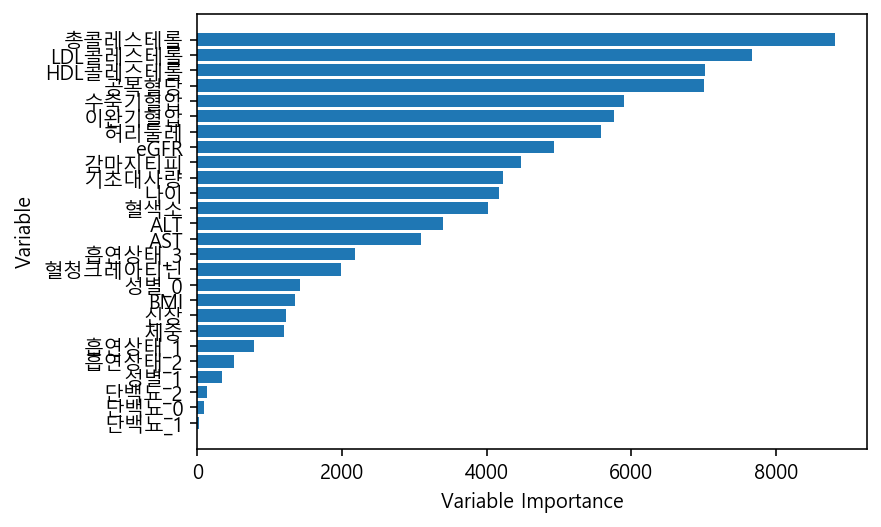

In [13]:
df_importance = pd.DataFrame(list(model.get_fscore().items()), columns=['Variable', 'Importance'])

df_importance.sort_values('Importance', ascending=False, inplace=True)
# df_importance.round(3)
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Variable'])
plt.xlabel('Variable Importance')
plt.ylabel('Variable')

#### GBM

In [14]:
gb_final = GradientBoostingClassifier(random_state = 1234,
                                learning_rate = 0.04, n_estimators = 300,
                                   max_depth = 7, min_samples_leaf = 5, min_samples_split = 10)
gb_final.fit(X_train, y_train)
y_pred = gb_final.predict(X_test)

# print('Accuracy on training set: {:.3f}'.format(gb_final.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(gb_final.score(X_test, y_test)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Accuracy on test set: 0.988
              precision    recall  f1-score   support

         저위험      0.994     0.998     0.996     13733
       중등도위험      0.982     0.965     0.973      4276
         고위험      0.976     0.980     0.978      2681
        최고위험      0.912     0.954     0.932       108

    accuracy                          0.988     20798
   macro avg      0.966     0.974     0.970     20798
weighted avg      0.988     0.988     0.988     20798



#### RF

In [15]:
rf_final = RandomForestClassifier(random_state = 1234, 
                                max_depth = 7, n_estimators = 500, min_samples_split = 2, 
                                  min_samples_leaf = 1)
rf_final.fit(X_train, y_train)

y_pred = rf_final.predict(X_test)
print('Accuracy: {0:.3f}\n'.format(rf_final.score(X_test, y_test)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Accuracy: 0.896

              precision    recall  f1-score   support

         저위험      0.899     0.991     0.943     13733
       중등도위험      0.869     0.673     0.759      4276
         고위험      0.918     0.793     0.851      2681
        최고위험      1.000     0.222     0.364       108

    accuracy                          0.896     20798
   macro avg      0.921     0.670     0.729     20798
weighted avg      0.896     0.896     0.890     20798



#### Logistic Reg

In [16]:
softmax_reg = LogisticRegression(multi_class = 'multinomial',
                                solver='lbfgs', C=10, random_state=1234)
softmax_reg.fit(X_train, y_train)

y_pred = softmax_reg.predict(X_test)
print('Accuracy: {0:.3f}\n'.format(softmax_reg.score(X_test, y_test)))
# print('Accuracy: {0:.3f}\n'.format(softmax_reg.score(X_test, y_test)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Accuracy: 0.768

              precision    recall  f1-score   support

         저위험      0.832     0.933     0.879     13733
       중등도위험      0.560     0.520     0.539      4276
         고위험      0.661     0.349     0.457      2681
        최고위험      0.000     0.000     0.000       108

    accuracy                          0.768     20798
   macro avg      0.513     0.451     0.469     20798
weighted avg      0.749     0.768     0.750     20798



C:\Users\Gyulee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### DT

In [17]:
tree_final = DecisionTreeClassifier(random_state = 1234,
                                  max_depth = 3, min_samples_split = 2, min_samples_leaf = 1)
tree_final.fit(X_train, y_train)

y_pred = tree_final.predict(X_test)
print('Accuracy: {0:.3f}\n'.format(tree_final.score(X_test, y_test)))
# print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

C:\Users\Gyulee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.816

              precision    recall  f1-score   support

         저위험      0.855     0.982     0.914     13733
       중등도위험      0.720     0.450     0.554      4276
         고위험      0.668     0.584     0.623      2681
        최고위험      0.000     0.000     0.000       108

    accuracy                          0.816     20798
   macro avg      0.561     0.504     0.523     20798
weighted avg      0.799     0.816     0.798     20798

